<a href="https://colab.research.google.com/github/QuantAnalyticsTorch/quant_analytics_torch/blob/main/examples/BlackApproximationDeepNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
import matplotlib.pyplot as plt

In [3]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [4]:
def black_torch(f, k, sdtv):
    n = torch.distributions.Normal(0, 1).cdf
    d1 = torch.log(f / k) / sdtv + sdtv / 2
    d2 = d1 - sdtv
    return f * n(d1) - k * n(d2)

In [5]:
black_torch(torch.tensor(1.),torch.tensor(1.),torch.tensor(0.2))

tensor(0.0797)

In [6]:
import numpy as np

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
import torch
import numpy as np

BATCH_SIZE = 10**4

In [62]:
TOTAL_DRAWS = 10**5

#s = np.random.uniform(0.5,1.5,TOTAL_DRAWS)
s = np.random.normal(1,0.1,TOTAL_DRAWS)
#k = np.random.uniform(0.5,1.5,TOTAL_DRAWS)
k = np.random.normal(1,0.2,TOTAL_DRAWS)
sdtv = np.random.uniform(0.1,0.5,TOTAL_DRAWS)

#xr = np.random.rand(TOTAL_DRAWS) * 2 * np.pi

X = np.zeros(shape=(TOTAL_DRAWS,3))
X[:,0] = s
X[:,1] = k
X[:,2] = sdtv
s_t = torch.tensor(s, requires_grad=True)
k_t = torch.tensor(k, requires_grad=True)
sdtv_t = torch.tensor(sdtv, requires_grad=True)
y = torch.zeros(size=(TOTAL_DRAWS,4))
bt = black_torch(s_t, k_t, sdtv_t).clone()
bt.sum().backward(retain_graph=True, create_graph=True)
y[:,0] = bt
y[:,1] = s_t.grad
y[:,2] = k_t.grad
y[:,3] = sdtv_t.grad

Xt = torch.tensor(X, requires_grad=True, dtype=torch.float32).to(device)
y = y.clone().detach().to(device)

X_train, X_val, y_train, y_val = train_test_split(Xt, y, test_size=0.2)

In [63]:
y

tensor([[ 0.2357,  0.7091, -0.5785,  0.3996],
        [ 0.0387,  0.2961, -0.2056,  0.2884],
        [ 0.0539,  0.5460, -0.4993,  0.4270],
        ...,
        [ 0.1722,  0.8293, -0.7747,  0.2507],
        [ 0.0477,  0.2468, -0.1359,  0.3001],
        [ 0.2310,  0.7112, -0.5549,  0.3409]], device='cuda:0')

In [64]:
from torch.utils.data import Dataset, DataLoader

In [65]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [66]:
train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(CustomDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True)

In [67]:
hidden_layer_size = 40

class FunctionApproximation(torch.nn.Module):
    def __init__(self):
        super(FunctionApproximation, self).__init__()
        self.regressor = torch.nn.Sequential(torch.nn.Linear(3, hidden_layer_size),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Linear(hidden_layer_size, hidden_layer_size),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Linear(hidden_layer_size, hidden_layer_size),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Linear(hidden_layer_size, hidden_layer_size),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Linear(hidden_layer_size, hidden_layer_size),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Linear(hidden_layer_size, 1))
    def forward(self, x):
        output = self.regressor(x)
        return output

In [68]:
model = FunctionApproximation().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = torch.nn.MSELoss(reduction="mean")

In [81]:
MAX_EPOCH = 5
BETA = 0.2

# training loop
train_loss_list = list()
val_loss_list = list()

input = torch.zeros(size=(BATCH_SIZE,1))

for epoch in range(MAX_EPOCH):
    print("epoch %d / %d" % (epoch+1, MAX_EPOCH))
    model.train()
    # training loop
    temp_loss_list = list()
    for X_train, y_train in train_dataloader:
        input = X_train.clone().detach().requires_grad_(True)

        model_output = model(input)

        model_output.sum().backward(retain_graph=True, create_graph=True)
        dX = input.grad

#        print(dX)

        input.requires_grad = False

        loss0 = criterion(input=model_output, target=y_train[:,0:1])
        loss1 = criterion(input=dX, target=y_train[:,1:4])        

        loss = loss0 + BETA * loss1
        print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # validation
    model.eval()

epoch 1 / 5
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
epoch 2 / 5
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
epoch 3 / 5
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.000

In [92]:
ytp = black_torch(s_t, torch.tensor(1), torch.tensor(0.4))

Xp = np.zeros(shape=(TOTAL_DRAWS,3))
Xp[:,0] = s
Xp[:,1] = 1
Xp[:,2] = 0.4

yt = model(torch.tensor(Xp, dtype=torch.float32).to(device))

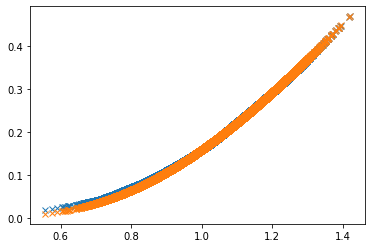

In [93]:
plt.plot(s,yt.detach().cpu().numpy(), 'x')
plt.plot(s_t.detach().cpu().numpy(),ytp.detach().cpu().numpy(), 'x')

In [88]:
ytp = black_torch(torch.tensor(1), torch.tensor(1), sdtv_t)

Xp = np.zeros(shape=(TOTAL_DRAWS,3))
Xp[:,0] = 1
Xp[:,1] = 1
Xp[:,2] = sdtv

yt = model(torch.tensor(Xp, dtype=torch.float32).to(device))

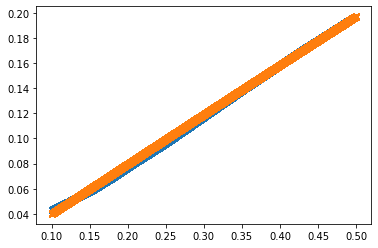

In [89]:
plt.plot(sdtv,yt.detach().cpu().numpy(), 'x')
plt.plot(sdtv_t.detach().cpu().numpy(),ytp.detach().cpu().numpy(), 'x')